# Import Packages

In [1]:
import numpy as np
import pandas as pd
import re, warnings, html, torch, umap, time, sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from skopt import BayesSearchCV
from skopt.space import Categorical
from sklearn.base import BaseEstimator
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.utils import point_asdict
from collections import deque
from transformers import AutoTokenizer, AutoModel
import os, joblib, json

warnings.filterwarnings("ignore", category=UserWarning)

# Load Data

In [2]:
df_min_cleaned = pd.read_csv("min_cleaned_tweets.csv")
texts = df_min_cleaned["clean_text"].astype(str).tolist()

df_min_cleaned_sample = pd.read_csv("min_cleaned_sample_tweets.csv")

# Embedding

In [3]:
# ---------------------------
# CONFIG
# ---------------------------
EMB_DIM = 768
RANDOM_STATE = 42

# ----------------------------------------------------------
# Load CardiffNLP tweet RoBERTa sentiment (no normalization)
# ----------------------------------------------------------
warnings.filterwarnings("ignore")
assert 'df_min_cleaned' in globals(), "Expected df_min_cleaned to be defined."
required = {'airline_sentiment','sentiment_confidence','clean_text'}
missing = required - set(df_min_cleaned.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df_min_cleaned.dropna(subset=['clean_text']).reset_index(drop=True).copy()

y_true_str = df['airline_sentiment'].astype(str).values
unique_true = {s:i for i,s in enumerate(sorted(pd.unique(y_true_str)))}
y_true = np.array([unique_true[s] for s in y_true_str], dtype=int)
K_TRUE = int(len(unique_true))
print("Classes:", unique_true, "| K_TRUE:", K_TRUE)

HF_MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
MAX_LENGTH = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else ("mps" if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else "cpu"))
print("Using device:", DEVICE)

tok = AutoTokenizer.from_pretrained(HF_MODEL_NAME, use_fast=True)
enc_model = AutoModel.from_pretrained(HF_MODEL_NAME).to(DEVICE).eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

@torch.no_grad()
def embed_texts(batch_texts, batch_size=64):
    chunks = []
    for i in tqdm(range(0, len(batch_texts), batch_size), desc="Embedding"):
        b = batch_texts[i:i+batch_size]
        enc = tok(b, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        enc = {k:v.to(DEVICE) for k,v in enc.items()}
        out = enc_model(**enc)
        pooled = mean_pool(out.last_hidden_state, enc['attention_mask'])
        chunks.append(pooled.detach().cpu().numpy().astype("float32"))
        del enc, out, pooled
        if DEVICE.type == 'cuda':
            torch.cuda.empty_cache()
    return np.vstack(chunks)

def text_to_roberta_avg(sent, roberta, emb_dim=EMB_DIM):
    toks = [re.sub(r'^\W+|\W+$', '', t.lower()) for t in str(sent).split()]
    vecs = [roberta[t] for t in toks if t in roberta]
    if not vecs:
        return np.zeros(emb_dim, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

def batch_embed(texts, roberta, emb_dim=EMB_DIM):
    return np.vstack([text_to_roberta_avg(s, roberta, emb_dim) for s in texts])

# ---------------------------
# Prepare Data
# ---------------------------
texts_sample = df_min_cleaned_sample["clean_text"].astype(str).tolist()
texts_full   = df_min_cleaned["clean_text"].astype(str).tolist()

# Align labels from df (same row order)
le = LabelEncoder()
le.fit(df["airline_sentiment"].astype(str))
y_sample = le.transform(df.loc[df_min_cleaned_sample.index, "airline_sentiment"].astype(str))
y_full   = le.transform(df.loc[df_min_cleaned.index, "airline_sentiment"].astype(str))

# ----------------------------------------------------------
# Compute or load cached CardiffNLP RoBERTa embeddings
# ----------------------------------------------------------
os.makedirs("model", exist_ok=True)

EMB_PATH = "model/X_cardiff_full.npy"

if os.path.exists(EMB_PATH):
    print("Loading cached embeddings...")
    X_cardiff_full = np.load(EMB_PATH, mmap_mode="r")
else:
    print("Computing embeddings (first run)...")
    X_cardiff_full = embed_texts(texts_full)
    np.save(EMB_PATH, X_cardiff_full)
    print(f"Saved embeddings → {EMB_PATH}")

SAMPLE_PATH = "model/X_cardiff_sample.npy"

if os.path.exists(SAMPLE_PATH):
    print("Loading cached sample embeddings...")
    X_cardiff_sample = np.load(SAMPLE_PATH, mmap_mode="r")
else:
    print("Computing sample embeddings (first run)...")
    X_cardiff_sample = embed_texts(texts_sample)
    np.save(SAMPLE_PATH, X_cardiff_sample)
    print(f"Saved sample embeddings → {SAMPLE_PATH}")

Classes: {'negative': 0, 'neutral': 1, 'positive': 2} | K_TRUE: 3
Using device: mps
Loading cached embeddings...
Loading cached sample embeddings...


# Helper Functions

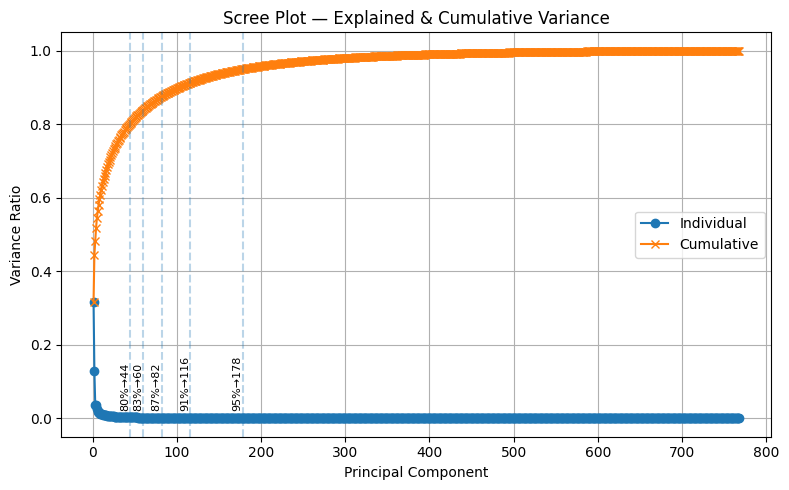

PCA n_components candidates (80–95% cum var): [44, 60, 82, 116, 178]


In [4]:
# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    if max_components is None:
        max_components = min(EMB_DIM, X.shape[1])
    Xs   = StandardScaler().fit_transform(X)
    pca  = PCA(n_components=max_components, random_state=RANDOM_STATE)
    pca.fit(Xs)
    evr  = pca.explained_variance_ratio_
    cum  = np.cumsum(evr)

    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # dedupe while preserving order
    seen = set(); comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c); seen.add(c)

    # ensure exactly k values (best-effort padding)
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate); seen.add(candidate)
        else:
            candidate = min(max_components, candidate+1)
            if candidate not in seen:
                comps_unique.append(candidate); seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    if plot:
        xs = np.arange(1, len(evr)+1)
        plt.figure(figsize=(8,5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t*100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component'); plt.ylabel('Variance Ratio')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return comps_unique, cum

pca_candidates, _cum = pick_pca_candidates(
    X_cardiff_sample, pct_low=0.80, pct_high=0.95, k=5, max_components=EMB_DIM, plot=True
)
print("PCA n_components candidates (80–95% cum var):", pca_candidates)

# Fixed UMAP candidate grids (your choices)
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline class (for BayesSearchCV)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        # record the params actually used (for robust logging)
        _LAST_TRIAL.clear()
        _LAST_TRIAL.append({
            'reducer'          : self.reducer,
            'n_components'     : self.n_components,
            'n_neighbors'      : self.n_neighbors,
            'min_dist'         : self.min_dist,
            'n_components_umap': self.n_components_umap,
            'model'            : self.model,
            'cov_type'         : self.cov_type,
            'linkage'          : self.linkage,
        })
        # ---------------- Reducer ----------------
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE,
                n_epochs=120,
                low_memory=True
            ).fit_transform(X_l2)

        # ---------------- Clustering ----------------
        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan', random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:  # Agglo
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        # store for score()
        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_

# BayesSearchCV

In [7]:
# ---------------------------
# Bayesian Search Space 
# ---------------------------
search_spaces = [
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback for BayesSearchCV (with robust fallback) ---
TOTAL_ITERS = 60 

_timings = []
_start = [None]
_prev  = [None]

def _short_params(d):
    keys = [
        'reducer','n_components','n_neighbors','min_dist','n_components_umap',
        'model','cov_type','linkage'
    ]
    return {k: d[k] for k in keys if k in d}

def _infer_branch_from_space(space):
    """Infer branch name (reducer+model) from single-choice categories in subspace."""
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if not cats or not hasattr(cats, "__iter__"):
            continue
        if len(cats) == 1:
            v = cats[0]
            if v in ("pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    import time, numpy as np
    now = time.perf_counter()
    if _start[0] is None:
        _start[0] = now
    if _prev[0] is not None:
        _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try to get the reducer/model from the latest evaluated point
    branch = None
    try:
        if res.x_iters:
            last_params = point_asdict(res.space, res.x_iters[-1])
            r, m = last_params.get("reducer"), last_params.get("model")
            if r and m:
                branch = f"{r}+{m}"
    except Exception:
        pass

    # Fallback: infer directly from this subspace definition
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch}",
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run Bayesian SearchCV
# ---------------------------
n = X_cardiff_sample.shape[0]
dummy_y = np.zeros(n, dtype=int)
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,           
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,                          # uses estimator.score() (silhouette)
    cv=cv_full,
    n_points=4,                            # parallel proposals
    n_jobs=-1,                             # parallel fits
    return_train_score=False
)

print("\n=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===")
callbacks = [
    DeltaYStopper(delta=1e-4, n_best=15),
    progress_callback
]

# prime timers for clean first measurement
_prev[0] = time.perf_counter()
_start[0] = _prev[0]

# === Refit best params on FULL data and save ===
os.makedirs("model", exist_ok=True)
SUBSET_PIPE = "model/cardiff_pipeline.pkl"
META_JSON   = "model/cardiff_pipeline_meta.json"


if os.path.exists(SUBSET_PIPE) and os.path.exists(META_JSON):
   print("Cached best pipeline & meta already exist.")
else:
   print("Running BayesSearchCV (first time or meta missing)...")
   search.fit(X_cardiff_sample, dummy_y, callback=callbacks)
   best_estimator = search.best_estimator_


   # ============================================================
   # AFTER: search.fit(X_cardiff_sample, dummy_y, callback=callbacks)
   # Build and persist per-branch best (subset), then pick
   # the FULL-data winner by Hungarian and save the fitted model.
   # ============================================================
   cv = pd.DataFrame(search.cv_results_)
   param_cols = [c for c in cv.columns if c.startswith("param_")]
   score_col  = "mean_test_score"


   # ---- 1) Per-branch best on subset (by silhouette) ----
   cv["branch"] = cv.apply(lambda r: f"{r.get('param_reducer')}+{r.get('param_model')}", axis=1)
   best_idx = cv.groupby("branch")[score_col].idxmax()
   best_rows = cv.loc[best_idx].reset_index(drop=True)


   branch_best = {}
   for _, r in best_rows.iterrows():
       params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
       # cast numerics
       for k in ("n_components","n_neighbors","n_components_umap"):
           if k in params and params[k] is not None: params[k] = int(params[k])
       if "min_dist" in params and params["min_dist"] is not None:
           params["min_dist"] = float(params["min_dist"])
       key = f"{params.get('reducer')}+{params.get('model')}"
       branch_best[key] = {
           "silhouette_subset": float(r[score_col]),
           **params
       }


   # ---- 2) Evaluate each branch winner on FULL data; pick Hungarian winner ----
   assert "X_cardiff_full" in globals(), "Need X_cardiff_full in memory."
   assert "y_full" in globals(), "Need y_full labels to compute Hungarian."


   full_eval_rows = []
   best_hungarian = -1.0
   best_record    = None
   best_fitted    = None


   for bkey, rec in branch_best.items():
       params = {k: rec.get(k) for k in [
           "reducer","model","n_components","n_neighbors","min_dist",
           "n_components_umap","cov_type","linkage"
       ] if rec.get(k) is not None}


       mdl = ClusteringPipeline(**params).fit(X_cardiff_full)
       labels = mdl.labels_
       metric = getattr(mdl, "metric", "cosine")
       sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_full, labels, metric)


       row = {
           "branch": bkey,
           "params": params,
           "Silhouette": float(sil),
           "ARI": float(ari),
           "NMI": float(nmi),
           "Hungarian": float(acc),
           "metric_used": metric
       }
       full_eval_rows.append(row)


       if acc > best_hungarian:
           best_hungarian = acc
           best_record    = row
           best_fitted    = mdl


   # ---- 3) Persist meta → cardiff_pipeline_meta.json ----
   META_JSON = "model/cardiff_pipeline_meta.json"
   meta_payload = {
       "branch_bests": branch_best,      # per-branch best on subset (silhouette)
       "full_eval": full_eval_rows,      # each branch refit on FULL with all metrics
       "winner_metric": "Hungarian",
       "winner": {
           "branch": best_record["branch"],
           "params": best_record["params"],
           "Silhouette": best_record["Silhouette"],
           "ARI": best_record["ARI"],
           "NMI": best_record["NMI"],
           "Hungarian": best_record["Hungarian"],
           "metric_used_for_silhouette": best_record["metric_used"]
       }
   }
   with open(META_JSON, "w") as f:
       json.dump(meta_payload, f, indent=2)
   print(f"Saved meta (per-branch + full eval + winner) → {META_JSON}")


   # ---- 4) Save the best FULL model by Hungarian → cardiff_pipeline.pkl ----
   SUBSET_PIPE = "model/cardiff_pipeline.pkl"
   joblib.dump(best_fitted, SUBSET_PIPE)
   print(f"Saved BEST (by Hungarian on FULL) pipeline → {SUBSET_PIPE}")


=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===
Running BayesSearchCV (first time or meta missing)...
[Bayes] iter   4/60 ( 6.7%) | last  9.93s avg  9.93s | elapsed  0.2m ETA ~ 9.3m | branch pca+kmeans
[Bayes] iter   8/60 (13.3%) | last  8.42s avg  9.18s | elapsed  0.3m ETA ~ 8.0m | branch pca+kmeans
[Bayes] iter  12/60 (20.0%) | last  0.91s avg  6.42s | elapsed  0.3m ETA ~ 5.1m | branch pca+kmeans
[Bayes] iter  16/60 (26.7%) | last  1.10s avg  5.09s | elapsed  0.3m ETA ~ 3.7m | branch pca+kmeans
[Bayes] iter  20/60 (33.3%) | last  1.23s avg  4.32s | elapsed  0.4m ETA ~ 2.9m | branch pca+kmeans
[Bayes] iter  24/60 (40.0%) | last  1.27s avg  3.81s | elapsed  0.4m ETA ~ 2.3m | branch pca+kmeans
[Bayes] iter  28/60 (46.7%) | last  1.60s avg  3.49s | elapsed  0.4m ETA ~ 1.9m | branch pca+kmeans
[Bayes] iter  32/60 (53.3%) | last  1.73s avg  3.27s | elapsed  0.4m ETA ~ 1.5m | branch pca+kmeans
[Bayes] iter  36/60 (60.0%) | last  1.96s avg  3.13s | elapsed  0.5m ETA ~ 1.3m | bra

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[Bayes] iter   4/60 ( 6.7%) | last 25.90s avg  3.90s | elapsed  3.0m ETA ~ 3.6m | branch umap+kmeans


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[Bayes] iter   8/60 (13.3%) | last 25.18s avg  4.35s | elapsed  3.4m ETA ~ 3.8m | branch umap+kmeans


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[Bayes] iter  12/60 (20.0%) | last 23.87s avg  4.76s | elapsed  3.8m ETA ~ 3.8m | branch umap+kmeans
[Bayes] iter  16/60 (26.7%) | last 22.45s avg  5.12s | elapsed  4.2m ETA ~ 3.8m | branch umap+kmeans
[Bayes] iter  20/60 (33.3%) | last 22.36s avg  5.47s | elapsed  4.6m ETA ~ 3.6m | branch umap+kmeans
[Bayes] iter  24/60 (40.0%) | last 19.18s avg  5.74s | elapsed  4.9m ETA ~ 3.4m | branch umap+kmeans
[Bayes] iter  28/60 (46.7%) | last 22.55s avg  6.06s | elapsed  5.3m ETA ~ 3.2m | branch umap+kmeans
[Bayes] iter  32/60 (53.3%) | last 21.66s avg  6.35s | elapsed  5.6m ETA ~ 3.0m | branch umap+kmeans
[Bayes] iter  36/60 (60.0%) | last 27.92s avg  6.75s | elapsed  6.1m ETA ~ 2.7m | branch umap+kmeans
[Bayes] iter  40/60 (66.7%) | last 24.28s avg  7.07s | elapsed  6.5m ETA ~ 2.4m | branch umap+kmeans
[Bayes] iter  44/60 (73.3%) | last 19.46s avg  7.29s | elapsed  6.8m ETA ~ 1.9m | branch umap+kmeans
[Bayes] iter  48/60 (80.0%) | last 18.45s avg  7.49s | elapsed  7.1m ETA ~ 1.5m | branch um

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Saved meta (per-branch + full eval + winner) → model/cardiff_pipeline_meta.json
Saved BEST (by Hungarian on FULL) pipeline → model/cardiff_pipeline.pkl


In [8]:
META_JSON = "model/cardiff_pipeline_meta.json"
assert os.path.exists(META_JSON), "Missing model/cardiff_pipeline_meta.json — run the tuning step first."


with open(META_JSON, "r") as f:
   meta = json.load(f)


# ---------------------------
# Build: Best per branch (CardiffNLP, 20% subset) table
# ---------------------------
branch_bests = meta["branch_bests"]  # dict: key="reducer+model" → params + silhouette_subset


rows = []
for branch, rec in sorted(branch_bests.items()):
   rows.append({
       "branch": branch,
       "best_sil_subset": round(float(rec.get("silhouette_subset", np.nan)), 4),
       "reducer": rec.get("reducer"),
       "model": rec.get("model"),
       "n_components": rec.get("n_components"),
       "n_neighbors": rec.get("n_neighbors"),
       "min_dist": rec.get("min_dist"),
       "n_components_umap": rec.get("n_components_umap"),
       "cov_type": rec.get("cov_type"),
       "linkage": rec.get("linkage"),
   })


df_best_subset = pd.DataFrame(rows).sort_values("branch")


print("\n================ Best Parameters per Branch (CardiffNLP, 20% subset) ================\n")
print(df_best_subset[[
   "branch","best_sil_subset","reducer","model","n_components",
   "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))


# ---------------------------
# Build: Final Evaluation on Full table
# ---------------------------
def _params_compact(d):
   # compact, branch-aware param string
   out = [f"reducer={d['reducer']}", f"model={d['model']}"]
   if d["reducer"] == "pca":
       if d.get("n_components") is not None: out.append(f"n_components={d['n_components']}")
   elif d["reducer"] == "umap":
       for k in ("n_neighbors","min_dist","n_components_umap"):
           if d.get(k) is not None: out.append(f"{k}={d[k]}")
   if d["model"] == "gmm" and d.get("cov_type") is not None:
       out.append(f"cov_type={d['cov_type']}")
   if d["model"] == "agglo" and d.get("linkage") is not None:
       out.append(f"linkage={d['linkage']}")
   return ", ".join(out)


full_eval_rows = meta["full_eval"]  # list of dicts for each branch (Silhouette, ARI, NMI, Hungarian, params, etc.)


final_rows = []
for rec in sorted(full_eval_rows, key=lambda x: x["branch"]):
   params = rec["params"]
   row = {
       "branch": rec["branch"],
       "Silhouette": round(float(rec["Silhouette"]), 3) if rec["Silhouette"] is not None else np.nan,
       "ARI": round(float(rec["ARI"]), 3) if rec["ARI"] is not None else np.nan,
       "NMI": round(float(rec["NMI"]), 3) if rec["NMI"] is not None else np.nan,
       "Hungarian": round(float(rec["Hungarian"]), 3) if rec["Hungarian"] is not None else np.nan,
       "Params": _params_compact(params)
   }
   final_rows.append(row)


df_final = pd.DataFrame(final_rows).sort_values("branch")


print("\n================ Final Evaluation on Full Minimal-Cleaned Data (CardiffNLP — Best of Each Branch) ================\n")
print(df_final[["branch","Silhouette","ARI","NMI","Hungarian","Params"]].to_string(index=False))


# ---------------------------
# Winner lines (guard against all-NaN columns)
# ---------------------------
for metric in ["Silhouette","ARI","NMI","Hungarian"]:
   ser = df_final[metric]
   if ser.notna().any():
       r = df_final.loc[ser.idxmax()]
       print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")



================ Best Parameters per Branch (CardiffNLP, 20% subset) ================

     branch  best_sil_subset reducer  model  n_components  n_neighbors  min_dist  n_components_umap cov_type linkage
  pca+agglo           0.3145     pca  agglo          82.0          NaN       NaN                NaN     None average
    pca+gmm           0.2539     pca    gmm          44.0          NaN       NaN                NaN     tied    None
 pca+kmeans           0.4006     pca kmeans          44.0          NaN       NaN                NaN     None    None
 umap+agglo           0.7171    umap  agglo           NaN        200.0       0.1               32.0     None average
   umap+gmm           0.5293    umap    gmm           NaN        200.0       0.1               48.0     full    None
umap+kmeans           0.7279    umap kmeans           NaN        200.0       0.1               32.0     None    None

================ Final Evaluation on Full Minimal-Cleaned Data (CardiffNLP — Best of Each Br

# Visualisation

Best model (by Hungarian): pca+gmm
Params: {'reducer': 'pca', 'model': 'gmm', 'n_components': 44, 'cov_type': 'tied'}


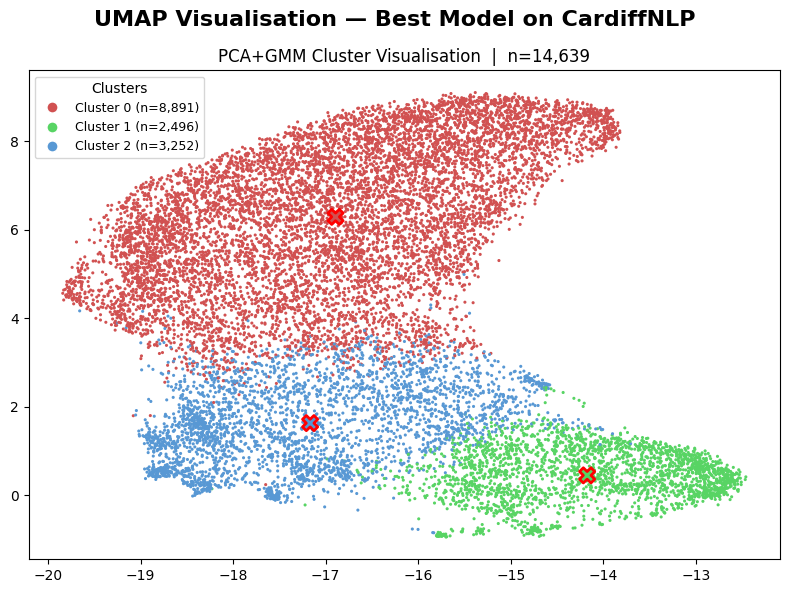

In [10]:
# ===========================
# Visualise the best saved model (Hungarian winner)
# ===========================


RANDOM_STATE = 42
palette = ["#d15151", "#58d464", "#5898d4"]  # red / green / blue


# Load saved artifacts
META_JSON = "model/cardiff_pipeline_meta.json"
PIPE_PATH = "model/cardiff_pipeline.pkl"
EMB_PATH  = "model/X_cardiff_full.npy"


with open(META_JSON, "r") as f:
   meta = json.load(f)
winner = meta["winner"]


print(f"Best model (by Hungarian): {winner['branch']}")
print("Params:", winner["params"])


best = joblib.load(PIPE_PATH)
X_sbert_full = np.load(EMB_PATH, mmap_mode="r")
labels = best.labels_


# ---------------------------
# Reduce to 2D for plotting
# ---------------------------
umap_2d = umap.UMAP(
   n_neighbors=50, min_dist=0.1, n_components=2,
   metric="euclidean", random_state=RANDOM_STATE
)
X_vis = umap_2d.fit_transform(best.X_use_)   # use the same normalized feature space used for clustering


# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 6))
colors = np.array(palette)[labels]
ax.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=5, edgecolor="none")


# Legend
unique, counts = np.unique(labels, return_counts=True)
handles = [plt.Line2D([0],[0], marker='o', color='w',
                     label=f"Cluster {k} (n={counts[i]:,})",
                     markerfacecolor=palette[k], markersize=8)
          for i,k in enumerate(unique)]
ax.legend(handles=handles, title="Clusters", loc="best", fontsize=9)


# Centroids
centroids = np.vstack([X_vis[labels==k].mean(axis=0) for k in unique])
ax.scatter(centroids[:,0], centroids[:,1], s=120, marker="X",
          c=[palette[k] for k in unique], edgecolor="red", linewidth=2.0, zorder=3)


# Titles
ax.set_title(f"{winner['branch'].upper()} Cluster Visualisation  |  n={len(labels):,}", fontsize=12)
plt.suptitle("UMAP Visualisation — Best Model on CardiffNLP", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()
